In [1]:
# if "preprocessing" folder in current folders -> cd back to original folder
%cd /content
import os
if os.path.exists("bsc-thesis"):
  # if bsc-thesis folder already exists; completely remove
  !rm -rf bsc-thesis

# this makes sure cached files are readily available (for calling e.g. `gather_data_cached`)
!apt-get install git-lfs
!git lfs install

# cloning repo
branch = "main"
!git clone --branch $branch https://github.com/maviddoerdijk/bsc-thesis.git

# moving into project dir
%cd bsc-thesis/src
%ls

/content
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Git LFS initialized.
Cloning into 'bsc-thesis'...
remote: Enumerating objects: 606, done.
remote: Counting objects: 100% (350/350), done.
remote: Compressing objects: 100% (257/257), done.
remote: Total 606 (delta 183), reused 213 (delta 84), pack-reused 256 (from 1)
Receiving objects: 100% (606/606), 23.52 MiB | 12.68 MiB/s, done.
Resolving deltas: 100% (330/330), done.
Filtering content: 100% (14/14), 1.75 GiB | 61.83 MiB/s, done.
/content/bsc-thesis/src
backtesting/  data/      main.ipynb  models/         utils/
config/       external/  main.py     preprocessing/


In [2]:
!pip install numpy==1.26.3 # necessary for bug fix
!pip install peft==0.10.0
!pip install ta
!pip install pykalman
!pip install PyWavelets
!pip install curl-cffi

## specific packages for time moe
# need a different version of accelerate because of bug "ImportError: cannot import name 'clear_device_cache' from 'accelerate.utils.memory'"
!pip install -U accelerate==0.32.0 # standard google colab version is 1.6.0 (apr 1, 2025), but for stability, we use time moe's 0.28.0 (mar 12, 2024)
!pip install transformers==4.40.1 # standard google colab version is 4.51.3, but time moe repo requirements mention/prefer 4.40.1 for stability
!pip install datasets==2.18.0
FLASH_ATTN = False # set to true if using this
if FLASH_ATTN:
  !pip install flash-attn==2.6.3 # optional but recommended by the repo

In [3]:
!pip show numpy

Name: numpy
Version: 1.26.3
Summary: Fundamental package for array computing in Python
Home-page: https://numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: Copyright (c) 2005-2023, NumPy Developers.
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are
met:

    * Redistributions of source code must retain the above copyright
       notice, this list of conditions and the following disclaimer.

    * Redistributions in binary form must reproduce the above
       copyright notice, this list of conditions and the following
       disclaimer in the documentation and/or other materials provided
       with the distribution.

    * Neither the name of the NumPy Developers nor the names of any
       contributors may be used to endorse or promote products derived
       from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYR

In [3]:
# Module imports
import pandas as pd
import numpy as np
from typing import Optional, Callable, Dict, Any
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm.auto import tqdm # note: using tqdm.auto usually automatically chooses the right import based on whether you're in CLI, notebook or somewhere else
import torch.nn as nn
import itertools
from pykalman import KalmanFilter
import ast
import re
from tabulate import tabulate
from datetime import datetime

# Custom Imports
from models.statistical_models import create_dataset, default_normalize, rmse_metric, acc_metric, kalman_filter_average, kalman_filter_regression, kalman_filter_regression_multivariate
from preprocessing.cointegration import find_cointegrated_pairs
from preprocessing.data_preprocessing import filter_pairs_data
from preprocessing.technical_indicators import combine_pairs_data
from preprocessing.wavelet_denoising import wav_den
from preprocessing.filters import step_1_filter_remove_nans, step_2_filter_liquidity
from backtesting.trading_strategy import trade
from backtesting.utils import calculate_return_uncertainty
from utils.visualization import plot_return_uncertainty, plot_comparison

# important for time moe
import wandb
wandb.login()

## workflow imports
from models.statistical_models import execute_kalman_workflow
from models.transformer_model import execute_transformer_workflow
from models.time_moe_model import execute_timemoe_workflow

## specific caching imports (should be changed in case you want to gather data live)
from data.scraper import load_cached_etf_tickers
from data.data_collection_cache import gather_data_cached, _get_filename

# Any other changes to be made throughout the entire notebook
plt.style.use('seaborn-v0_8')

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: davidmoerdijk (davidmoerdijk-smart-backoffice) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


# All timeperiods:
```
# startDateStr = '2010-10-01'
# endDateStr = '2024-10-02'
# startDateStr = '2008-10-01'
# endDateStr = '2018-10-02'
# startDateStr = '2007-01-01'
# endDateStr = '2021-12-31'
# startDateStr = '2007-01-01'
# endDateStr = '2024-12-31'
# startDateStr = '2007-01-01'
# endDateStr = '2016-12-31'
# startDateStr = '2007-01-01'
# endDateStr = '2021-12-31'
```

## 1. Data gathering and filtering

In [4]:
# Step 1: Gather cached data and filter pairs based on cointegration and such
# NOTE: all the functions used here are explained in much more detail in src/main.ipynb, but this notebook is simply focused on finding how to ge the Transformer model to work as I wish.
startDateStr = '2008-10-01'
endDateStr = '2018-10-02' # documentation said that endDateStr is exclusive for both yahoofinance and the original code, but actually printing the shapes showed otherwise..
instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
pairs_data = {key:value[1]  for (key, value) in pairs.items()}
pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.
# Extract the most highly cointegrated pairs
ticker_a, ticker_b = pairs_data_filtered[0][0][0], pairs_data_filtered[0][0][1]
pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
# Note about pairs_timeseries_df: the timeseries output on which we should train are found in the key "Spread_Close"
# But, also the input features are the following keys: ['S1_rsi', 'S2_rsi', 'S1_mfi', 'S2_mfi', 'S1_adi', 'S2_adi', 'S1_vpt', 'S2_vpt', 'S1_atr', 'S2_atr', 'S1_bb_ma', 'S2_bb_ma', 'S1_adx', 'S2_adx', 'S1_ema', 'S2_ema', 'S1_macd', 'S2_macd', 'S1_dlr', 'S2_dlr']

Processing pairs: 100%|██████████| 820/820 [01:53<00:00,  7.24it/s]


Completed 820 pairs


## 2. Find best pair using Kalman Filters validation dataset

Gathering test MSE (and returns) for different pairs..:   0%|          | 0/95 [00:00<?, ?it/s]

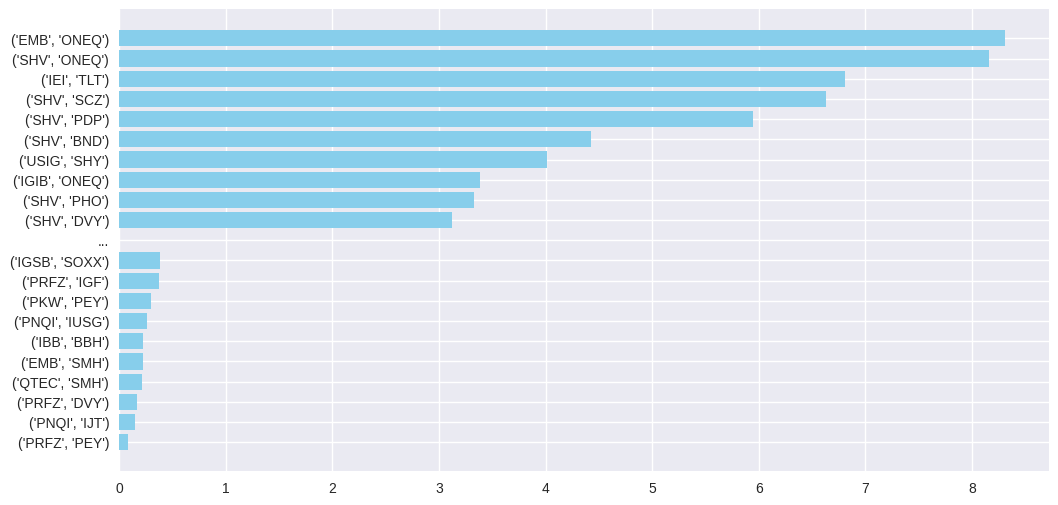

In [ ]:
# Step 2: From best cointegrated pairs, find highest validation MSE in Kalman Filters -> best pair
# Useful idea for the dev/validation data: go through all pairs, pick the pair with the highest validation MSE, and use that pair for getting a test MSE.
results = []
for i in tqdm(range(len(pairs_data_filtered)), desc = "Gathering test MSE (and returns) for different pairs.."):
    ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
    pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
    output = execute_kalman_workflow(pair_data=pairs_timeseries_df, verbose=False, pair_tup_str=f"({ticker_a},{ticker_b})")
    results.append((str(pairs_data_filtered[i][0]), output['val_mse']))

best_scoring_pair_idx = results.index(min(results, key=lambda x: x[1])) # index of the best tuple
results.sort(key=lambda x: x[1])  # sort by MSE
x = 10
top_x = results[:x]
bottom_x = results[-x:]
combined = top_x + [('...', None)] + bottom_x
labels = [item[0] for item in combined]
values = [item[1] for item in combined]
plt.figure(figsize=(12, 6))
bars = plt.barh(labels, [v if v is not None else 0 for v in values], color='skyblue')

In [ ]:
# Pick the lowest MSE tickers from that and get the new data
ticker_a, ticker_b = pairs_data_filtered[best_scoring_pair_idx][0][0], pairs_data_filtered[best_scoring_pair_idx][0][1]
pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)

## 3. Kalman Filter Results Test Dataset


In [ ]:
# Step 3: Use best pair for Kalman Filters
output_kalman = execute_kalman_workflow(pair_data=pairs_timeseries_df, verbose=True, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE), pair_tup_str=f"({ticker_a},{ticker_b})", add_technical_indicators=False)

kalman_val_mse = output_kalman['val_mse']
kalman_test_mse = output_kalman['test_mse']
kalman_yoy_returns_str = f"{output_kalman['yoy_mean'] * 100:.2f}% +- {output_kalman['yoy_std'] * 100:.2f}%"

output_kalman_without_ta = execute_kalman_workflow(pair_data=pairs_timeseries_df, verbose=True, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE), pair_tup_str=f"({ticker_a},{ticker_b})", add_technical_indicators=True)
kalman_val_mse_without_ta = output_kalman_without_ta['val_mse']
kalman_test_mse_without_ta = output_kalman_without_ta['test_mse']
kalman_yoy_returns_str_without_ta = f"{output_kalman_without_ta['yoy_mean'] * 100:.2f}% +- {output_kalman_without_ta['yoy_std'] * 100:.2f}%"

Split sizes — train: 2239, dev: 124, test: 125
Saved plot to data/results/data_2008_10_01_2018_10_02_4416cb3b_kalman/data_2008_10_01_2018_10_02_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_10_01_2018_10_02_4416cb3b_kalman/data_2008_10_01_2018_10_02_4416cb3b_groundtruth_comparison.png

Validation MSE: 1.8406249646631174
Test MSE: 1.998517429613437
YOY Returns: 1.32%
YOY Std: +- 0.44%
GT Yoy: 42.99%
Plot filepath parent dir: data/results
Plot filenames: {'yoy_returns': 'data_2008_10_01_2018_10_02_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_10_01_2018_10_02_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 2239, dev: 124, test: 125
Saved plot to data/results/data_2008_10_01_2018_10_02_4416cb3b_kalman/data_2008_10_01_2018_10_02_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_10_01_2018_10_02_4416cb3b_kalman/data_2008_10_01_2018_10_02_4416cb3b_groundtruth_comparison.png

Validation MSE: 0.

## 4. Transformer Results Test Dataset


In [ ]:
# Step 4: Use best pair for Transformers

output_transformer = execute_transformer_workflow(pairs_timeseries_df, verbose=True, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE), pair_tup_str=f"({ticker_a},{ticker_b})", epochs=20)
transformer_val_mse = output_transformer['val_mse']
transformer_test_mse = output_transformer['test_mse']
transformer_yoy_returns_str = f"{output_transformer['yoy_mean'] * 100:.2f}% +- {output_transformer['yoy_std'] * 100:.2f}%"

output_transformer_without_ta = execute_transformer_workflow(pairs_timeseries_df, verbose=True, add_technical_indicators=False, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE), pair_tup_str=f"({ticker_a},{ticker_b})", epochs=20)
transformer_val_mse_without_ta = output_transformer_without_ta['val_mse']
transformer_test_mse_without_ta = output_transformer_without_ta['test_mse']
transformer_yoy_returns_str_without_ta = f"{output_transformer_without_ta['yoy_mean'] * 100:.2f}% +- {output_transformer_without_ta['yoy_std'] * 100:.2f}%"

Split sizes — train: 2239, dev: 124, test: 125
Single tensor shape: torch.Size([64, 20, 34])
Epoch 010 | train MSE 0.002908 | val MSE 0.053656
Epoch 020 | train MSE 0.003371 | val MSE 0.046558
Test MSE  : 0.231429
Saved plot to data/results/data_2008_10_01_2018_10_02_4416cb3b_transformer/data_2008_10_01_2018_10_02_4416cb3b_train_val_loss.png
Saved plot to data/results/data_2008_10_01_2018_10_02_4416cb3b_transformer/data_2008_10_01_2018_10_02_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_10_01_2018_10_02_4416cb3b_transformer/data_2008_10_01_2018_10_02_4416cb3b_groundtruth_comparison.png

Validation MSE: 0.0465578637444056
Test MSE: 0.23142890632152557
YOY Returns: 21.81%
YOY Std: +- 0.00%
GT Yoy: 30.71%
Plot filepath parent dir: data/results
Plot filenames: {'yoy_returns': 'data_2008_10_01_2018_10_02_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_10_01_2018_10_02_4416cb3b_groundtruth_comparison.png', 'train_val_loss': 'data_2008_10_01_2018_10

## 5. Time-Moe Results Test Dataset


In [ ]:
# Step 5: Use best pair for Time-MoE.
output_time_moe = execute_timemoe_workflow(pairs_timeseries_df, verbose=True, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE), pair_tup_str=f"({ticker_a},{ticker_b})", load_finetuned=True)

time_moe_val_mse = output_time_moe['val_mse']
time_moe_test_mse = output_time_moe['test_mse']
time_moe_yoy_returns_str = f"{output_time_moe['yoy_mean'] * 100:.2f}% +- {output_time_moe['yoy_std'] * 100:.2f}%"

Split sizes — train: 2239, dev: 124, test: 125
devX_raw Shape: torch.Size([104, 20])
dev_loader tensor Shape: torch.Size([8, 20]), with a total of 13 batches


/content/bsc-thesis/src/models/time_moe_model.py:84: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  X = torch.tensor(X, dtype=torch.float32)


2025-05-20 11:02:25,033 - log_util.py[pid:2486;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/891 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/227M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

100%|██████████| 1/1 [00:00<00:00, 14926.35it/s]


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: davidmoerdijk (davidmoerdijk-smart-backoffice) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
1,0.029900


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


configuration_time_moe.py:   0%|          | 0.00/2.50k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Maple728/TimeMoE-50M:
- configuration_time_moe.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


Saved plot to data/results/data_2008_10_01_2018_10_02_4416cb3b_timemoe/data_2008_10_01_2018_10_02_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_10_01_2018_10_02_4416cb3b_timemoe/data_2008_10_01_2018_10_02_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.014303365722298622
  Test MSE: 0.043884843587875366
  YOY Returns: 0.62%
  YOY Std: +- 0.02%
  GT Yoy: -0.36%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_10_01_2018_10_02_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_10_01_2018_10_02_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  


## 6. Gather results into table


In [ ]:
# Step 6: Get a table for the entire results of this time period using .txt files
start_year = re.search(r"\d{4}", startDateStr).group()
end_year = re.search(r"\d{4}", endDateStr).group()

latex_table = f"""
\\begin{{table}}[h]
\\centering
\\resizebox{{\\textwidth}}{{!}}{{%
\\begin{{tabular}}{{|l|ccc|ccc|}}
\\hline
\\textbf{{Model}} & \\multicolumn{{3}}{{c|}}{{\\textbf{{{start_year}--{end_year}}}}} \\\\
 & \\textbf{{val MSE}} & \\textbf{{test MSE}} & \\textbf{{YoY Returns (std)}} \\\\
\\hline
Kalman Filter & {kalman_val_mse:.4f} & {kalman_test_mse:.4f} & {kalman_yoy_returns_str} \\\\
Kalman Filter$^{{excl}}$ & {kalman_val_mse_without_ta:.4f} & {kalman_test_mse_without_ta:.4f} & {kalman_yoy_returns_str_without_ta} \\\\
Transformer & {transformer_val_mse or 'TBD'} & {transformer_test_mse or 'TBD'} & {transformer_yoy_returns_str or 'TBD'} \\\\
Transformer$^{{excl}}$ & {transformer_val_mse_without_ta or 'TBD'} & {transformer_test_mse_without_ta or 'TBD'} & {transformer_yoy_returns_str_without_ta or 'TBD'} \\\\
Time-MoE$^{{excl}}$ & {time_moe_val_mse or 'TBD'} & {time_moe_test_mse or 'TBD'} & {time_moe_yoy_returns_str or 'TBD'} \\\\
\\hline
\\end{{tabular}}%
}}
\\end{{table}}
"""
print(latex_table)

headers = ["Model", f"{start_year}–{end_year} val MSE", "test MSE", "YoY Returns (std)"]
rows = [
    ["Kalman Filter", f"{kalman_val_mse:.4f}", f"{kalman_test_mse:.4f}", kalman_yoy_returns_str],
    ["Kalman Filter^excl", f"{kalman_val_mse_without_ta:.4f}", f"{kalman_test_mse_without_ta:.4f}", kalman_yoy_returns_str_without_ta],
    ["Transformer", transformer_val_mse or "TBD", transformer_test_mse or "TBD", transformer_yoy_returns_str or "TBD"],
    ["Transformer^excl", transformer_val_mse_without_ta or "TBD", transformer_test_mse_without_ta or "TBD", transformer_yoy_returns_str_without_ta or "TBD"],
    ["Time-MoE^excl", time_moe_val_mse or "TBD", time_moe_test_mse or "TBD", time_moe_yoy_returns_str or "TBD"]
]

print(tabulate(rows, headers=headers, tablefmt="grid"))


\begin{table}[h]
\centering
\resizebox{\textwidth}{!}{%
\begin{tabular}{|l|ccc|ccc|}
\hline
\textbf{Model} & \multicolumn{3}{c|}{\textbf{2008--2018}} \\
 & \textbf{val MSE} & \textbf{test MSE} & \textbf{YoY Returns (std)} \\
\hline
Kalman Filter & 1.8406 & 1.9985 & 1.32% +- 0.44% \\
Kalman Filter$^{excl}$ & 0.0804 & 0.0786 & 39.96% +- 2.72% \\
Transformer & 0.0465578637444056 & 0.23142890632152557 & 21.81% +- 0.00% \\
Transformer$^{excl}$ & 0.020511887394464932 & 0.1023695319890976 & 1.66% +- 0.53% \\
Time-MoE$^{excl}$ & TBD & TBD & TBD \\
\hline
\end{tabular}%
}
\end{table}

+--------------------+----------------------+---------------------+---------------------+
| Model              | 2008–2018 val MSE    | test MSE            | YoY Returns (std)   |
+====================+======================+=====================+=====================+
| Kalman Filter      | 1.8406               | 1.9985              | 1.32% +- 0.44%      |
+--------------------+----------------------+-----------

## 7. Repeat for 5 other time periods


In [ ]:
# Step 7: Make this into a function that gathers table at once, and repeat for all other time periods
def gather_results_timeperiod(startDateStr, endDateStr, train_frac, dev_frac, short_epochs = False):
  verbose = False

  instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
  data = gather_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
  data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
  data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

  scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
  pairs_data = {key:value[1]  for (key, value) in pairs.items()}
  pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
  pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.
  # Extract the most highly cointegrated pairs

  results = []
  for i in tqdm(range(len(pairs_data_filtered)), desc = "Gathering test MSE (and returns) for different pairs.."):
      ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
      pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
      output = execute_kalman_workflow(pair_data=pairs_timeseries_df, verbose=verbose, pair_tup_str=f"({ticker_a},{ticker_b})", train_frac=train_frac, dev_frac=dev_frac)
      results.append((str(pairs_data_filtered[i][0]), output['val_mse']))

  best_scoring_pair_idx = results.index(min(results, key=lambda x: x[1])) # index of the best tuple

  ticker_a, ticker_b = pairs_data_filtered[best_scoring_pair_idx][0][0], pairs_data_filtered[best_scoring_pair_idx][0][1]
  pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
  print(f"Best scoring pair idx: {best_scoring_pair_idx}, means we're using pair ({ticker_a}, {ticker_b})")


  # Step 3: Use best pair for Kalman Filters
  output_kalman = execute_kalman_workflow(pair_data=pairs_timeseries_df, verbose=verbose, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE), pair_tup_str=f"({ticker_a},{ticker_b})", add_technical_indicators=False, train_frac=train_frac, dev_frac=dev_frac)

  print(f"a) pair_data shape: {pairs_timeseries_df.shape}")
  print(f"a) pair_data: {pairs_timeseries_df.head()[:3]}")
  print(f"b) spread_gt_series: [cannot access]")
  print(f"c) Best scoring pair idx: {best_scoring_pair_idx}, means we're using pair ({ticker_a}, {ticker_b})")


  kalman_val_mse = output_kalman['val_mse']
  kalman_test_mse = output_kalman['test_mse']
  kalman_yoy_returns_str = f"{output_kalman['yoy_mean'] * 100:.2f}% +- {output_kalman['yoy_std'] * 100:.2f}%"

  output_kalman_without_ta = execute_kalman_workflow(pair_data=pairs_timeseries_df, verbose=verbose, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE), pair_tup_str=f"({ticker_a},{ticker_b})", add_technical_indicators=True, train_frac=train_frac, dev_frac=dev_frac)
  kalman_val_mse_without_ta = output_kalman_without_ta['val_mse']
  kalman_test_mse_without_ta = output_kalman_without_ta['test_mse']
  kalman_yoy_returns_str_without_ta = f"{output_kalman_without_ta['yoy_mean'] * 100:.2f}% +- {output_kalman_without_ta['yoy_std'] * 100:.2f}%"

  # Step 4: Use best pair for Transformers
  transformer_epochs = 400
  if short_epochs:
    transformer_epochs = 20

  output_transformer = execute_transformer_workflow(pairs_timeseries_df, verbose=verbose, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE), pair_tup_str=f"({ticker_a},{ticker_b})", epochs=transformer_epochs, train_frac=train_frac, dev_frac=dev_frac)
  transformer_val_mse = output_transformer['val_mse']
  transformer_test_mse = output_transformer['test_mse']
  transformer_yoy_returns_str = f"{output_transformer['yoy_mean'] * 100:.2f}% +- {output_transformer['yoy_std'] * 100:.2f}%"

  output_transformer_without_ta = execute_transformer_workflow(pairs_timeseries_df, verbose=verbose, add_technical_indicators=False, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE), pair_tup_str=f"({ticker_a},{ticker_b})", epochs=transformer_epochs, train_frac=train_frac, dev_frac=dev_frac)
  transformer_val_mse_without_ta = output_transformer_without_ta['val_mse']
  transformer_test_mse_without_ta = output_transformer_without_ta['test_mse']
  transformer_yoy_returns_str_without_ta = f"{output_transformer_without_ta['yoy_mean'] * 100:.2f}% +- {output_transformer_without_ta['yoy_std'] * 100:.2f}%"

  # Step 5: Use best pair for Time-MoE.
  output_time_moe = execute_timemoe_workflow(pairs_timeseries_df, verbose=True, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE), pair_tup_str=f"({ticker_a},{ticker_b})", load_finetuned=True, train_frac=train_frac, dev_frac=dev_frac)

  time_moe_val_mse = output_time_moe['val_mse']
  time_moe_test_mse = output_time_moe['test_mse']
  time_moe_yoy_returns_str = f"{output_time_moe['yoy_mean'] * 100:.2f}% +- {output_time_moe['yoy_std'] * 100:.2f}%"

  # Step 6: Get a table for the entire results of this time period using .txt files
  start_year = re.search(r"\d{4}", startDateStr).group()
  end_year = re.search(r"\d{4}", endDateStr).group()

  # Some more formatting
  kalman_val_mse_formatted = f"{kalman_val_mse:.4f}" if kalman_val_mse is not None else 'TBD'
  kalman_test_mse_formatted = f"{kalman_test_mse:.4f}" if kalman_test_mse is not None else 'TBD'
  kalman_val_mse_without_ta_formatted = f"{kalman_val_mse_without_ta:.4f}" if kalman_val_mse_without_ta is not None else 'TBD'
  kalman_test_mse_without_ta_formatted = f"{kalman_test_mse_without_ta:.4f}" if kalman_test_mse_without_ta is not None else 'TBD'
  transformer_val_mse_formatted = f"{transformer_val_mse:.4f}" if transformer_val_mse is not None else 'TBD'
  transformer_test_mse_formatted = f"{transformer_test_mse:.4f}" if transformer_test_mse is not None else 'TBD'
  transformer_val_mse_without_ta_formatted = f"{transformer_val_mse_without_ta:.4f}" if transformer_val_mse_without_ta is not None else 'TBD'
  transformer_test_mse_without_ta_formatted = f"{transformer_test_mse_without_ta:.4f}" if transformer_test_mse_without_ta is not None else 'TBD'
  time_moe_val_mse_formatted = f"{time_moe_val_mse:.4f}" if time_moe_val_mse is not None else 'TBD'
  time_moe_test_mse_formatted = f"{time_moe_test_mse:.4f}" if time_moe_test_mse is not None else 'TBD'

  kalman_yoy_returns_str_escaped = kalman_yoy_returns_str.replace("%", "\\%")
  kalman_yoy_returns_str_without_ta_escaped = kalman_yoy_returns_str_without_ta.replace("%", "\\%")
  transformer_yoy_returns_str_escaped = transformer_yoy_returns_str.replace("%", "\\%")
  transformer_yoy_returns_str_without_ta_escaped = transformer_yoy_returns_str_without_ta.replace("%", "\\%")
  time_moe_yoy_returns_str_escaped = time_moe_yoy_returns_str.replace("%", "\\%")

  latex_table = f"""
  \\begin{{table}}[h]
  \\centering
  \\resizebox{{\\textwidth}}{{!}}{{%
  \\begin{{tabular}}{{|l|ccc|ccc|}}
  \\hline
  \\textbf{{Model}} & \\multicolumn{{3}}{{c|}}{{\\textbf{{{start_year}--{end_year}}}}} \\\\
  & \\textbf{{val MSE}} & \\textbf{{test MSE}} & \\textbf{{YoY Returns (std)}} \\\\
  \\hline
  Kalman Filter & {kalman_val_mse_formatted} & {kalman_test_mse_formatted} & {kalman_yoy_returns_str_escaped} \\\\
  Kalman Filter$^{{excl}}$ & {kalman_val_mse_without_ta_formatted} & {kalman_test_mse_without_ta_formatted} & {kalman_yoy_returns_str_without_ta_escaped} \\\\
  Transformer & {transformer_val_mse_formatted or 'TBD'} & {transformer_test_mse_formatted or 'TBD'} & {transformer_yoy_returns_str_escaped or 'TBD'} \\\\
  Transformer$^{{excl}}$ & {transformer_val_mse_without_ta_formatted or 'TBD'} & {transformer_test_mse_without_ta_formatted or 'TBD'} & {transformer_yoy_returns_str_without_ta_escaped or 'TBD'} \\\\
  Time-MoE$^{{excl}}$ & {time_moe_val_mse_formatted or 'TBD'} & {time_moe_test_mse_formatted or 'TBD'} & {time_moe_yoy_returns_str_escaped or 'TBD'} \\\\
  \\hline
  \\end{{tabular}}%
  }}
  \\end{{table}}
  """
  print(latex_table)

  headers = ["Model", f"{start_year}–{end_year} val MSE", "test MSE", "YoY Returns (std)"]
  rows = [
      ["Kalman Filter", f"{kalman_val_mse:.4f}", f"{kalman_test_mse:.4f}", kalman_yoy_returns_str],
      ["Kalman Filter^excl", f"{kalman_val_mse_without_ta:.4f}", f"{kalman_test_mse_without_ta:.4f}", kalman_yoy_returns_str_without_ta],
      ["Transformer", transformer_val_mse or "TBD", transformer_test_mse or "TBD", transformer_yoy_returns_str or "TBD"],
      ["Transformer^excl", transformer_val_mse_without_ta or "TBD", transformer_test_mse_without_ta or "TBD", transformer_yoy_returns_str_without_ta or "TBD"],
      ["Time-MoE^excl", time_moe_val_mse or "TBD", time_moe_test_mse or "TBD", time_moe_yoy_returns_str or "TBD"],
      ["Using Ground Truth Spread (According to Kalman)", "N/A", "N/A", output_kalman['gt_yoy'] or "TBD"],
      ["Using Ground Truth Spread (According to Kalman w/o TA)", "N/A", "N/A", output_kalman_without_ta['gt_yoy'] or "TBD"],
      ["Using Ground Truth Spread (According to Transformer)", "N/A", "N/A", output_transformer['gt_yoy'] or "TBD"],
      ["Using Ground Truth Spread (According to Transformer w/o TA)", "N/A", "N/A", output_transformer_without_ta['gt_yoy'] or "TBD"],
      ["Using Ground Truth Spread (According to Time MoE)", "N/A", "N/A", output_time_moe['gt_yoy'] or "TBD"]
  ]

  print(tabulate(rows, headers=headers, tablefmt="grid"))

  # save both tables to total_results
  total_results_dir = "data/results/total_results"
  os.makedirs(total_results_dir, exist_ok=True)

  with open(f"{total_results_dir}/table_{start_year}_{end_year}.tex", "w") as f:
      f.write(latex_table)

  with open(f"{total_results_dir}/table_{start_year}_{end_year}.txt", "w") as f:
      f.write(tabulate(rows, headers=headers, tablefmt="grid"))

def _get_train_dev_frac(startDateStr, endDateStr, startDateStrTest, endDateStrTest, verbose=False):
  """
  For certain periods, we want a specific testing period, and must therefore calculate the train/dev split based on that.
  """
  # convert all 4 dates to datetime
  startDateStr = datetime.strptime(startDateStr, '%Y-%m-%d')
  endDateStr = datetime.strptime(endDateStr, '%Y-%m-%d')
  startDateStrTest = datetime.strptime(startDateStrTest, '%Y-%m-%d')
  endDateStrTest = datetime.strptime(endDateStrTest, '%Y-%m-%d')

  total_days = (endDateStr - startDateStr).days
  test_days = (endDateStrTest - startDateStrTest).days
  train_days = total_days - 2 * test_days

  train_frac = train_days / total_days
  test_frac = test_days / total_days
  dev_frac = test_frac

  if verbose:
    print(f"train_frac: {train_frac}")
    print(f"dev_frac: {dev_frac}")
    print(f"test_frac: {test_frac}")

  return train_frac, dev_frac

## PERIOD 1
startDateStr1 = '2010-10-01'
endDateStr1 = '2024-10-02'
train_frac1 = 0.90
dev_frac1 = 0.05

## PERIOD 2
startDateStr2 = '2008-10-01'
endDateStr2 = '2018-10-02'
train_frac2 = 0.90
dev_frac2 = 0.05

## PERIOD 3
startDateStr3 = '2007-01-01'
endDateStr3 = '2022-12-31'
# wanted test year: test 2022/01-2022/12
startDateStrTest3 = '2022-01-01'
endDateStrTest3 = '2022-12-31'
train_frac3, dev_frac3 = _get_train_dev_frac(startDateStr3, endDateStr3, startDateStrTest3, endDateStrTest3)

## PERIOD 4
startDateStr4 = '2007-01-01'
endDateStr4 = '2024-12-31'
# test 2024/01-2024/12
startDateStrTest4 = '2024-01-01'
endDateStrTest4 = '2024-12-31'
train_frac4, dev_frac4 = _get_train_dev_frac(startDateStr4, endDateStr4, startDateStrTest4, endDateStrTest4)

## PERIOD 5
startDateStr5 = '2007-01-01'
endDateStr5 = '2016-12-31'
# test 2014/07-2016
startDateStrTest5 = '2014-07-01'
endDateStrTest5 = '2016-12-31'
train_frac5, dev_frac5 = _get_train_dev_frac(startDateStr5, endDateStr5, startDateStrTest5, endDateStrTest5)

## PERIOD 6
startDateStr6 = '2007-01-01'
endDateStr6 = '2021-12-31'
# test 2020/01-2021/12
startDateStrTest6 = '2020-01-01'
endDateStrTest6 = '2021-12-31'
train_frac6, dev_frac6 = _get_train_dev_frac(startDateStr6, endDateStr6, startDateStrTest6, endDateStrTest6)

all_inputs = [
    (startDateStr1, endDateStr1, train_frac1, dev_frac1),
    (startDateStr2, endDateStr2, train_frac2, dev_frac2),
    (startDateStr3, endDateStr3, train_frac3, dev_frac3),
    (startDateStr4, endDateStr4, train_frac4, dev_frac4),
    (startDateStr5, endDateStr5, train_frac5, dev_frac5),
    (startDateStr6, endDateStr6, train_frac6, dev_frac6)
]

# for inputs in all_inputs:
#   gather_results_timeperiod(*inputs)

# For now, we are only gathering results for time period 2007-2021 (period 6)
gather_results_timeperiod(startDateStr6, endDateStr6, train_frac6, dev_frac6, short_epochs=True)

Processing pairs: 100%|██████████| 253/253 [00:53<00:00,  4.72it/s]


Completed 253 pairs


Gathering test MSE (and returns) for different pairs..:   0%|          | 0/7 [00:00<?, ?it/s]

/content/bsc-thesis/src/models/statistical_models.py:276: RuntimeWarning: invalid value encountered in power
  gt_yoy = ((gt_returns[-1] / gt_returns[0])**(365 / len(gt_returns)) - 1)[0]
/content/bsc-thesis/src/backtesting/utils.py:53: RuntimeWarning: invalid value encountered in scalar power
  return ((mean_returns[-1] / mean_returns[0])**(365 / len(mean_returns)) - 1), ((std_returns[-1] / mean_returns[0]) * np.sqrt(365 / len(mean_returns)))
/content/bsc-thesis/src/models/statistical_models.py:276: RuntimeWarning: invalid value encountered in power
  gt_yoy = ((gt_returns[-1] / gt_returns[0])**(365 / len(gt_returns)) - 1)[0]


In [ ]:
# zip data/results
import shutil
shutil.make_archive('results', 'zip', 'data/results')

'/content/bsc-thesis/src/results.zip'

Let's go a little bit deeper into the GT trading results.

1. Reproducing Kalman Filter GT YoY results outside of its workflow function.

In [30]:
verbose = False
startDateStr, endDateStr, train_frac, dev_frac = startDateStr6, endDateStr6, train_frac6, dev_frac6

instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
pairs_data = {key:value[1]  for (key, value) in pairs.items()}
pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.
# Extract the most highly cointegrated pairs

results = []
for i in tqdm(range(len(pairs_data_filtered)), desc = "Gathering test MSE (and returns) for different pairs.."):
    ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
    pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
    output = execute_kalman_workflow(pair_data=pairs_timeseries_df, verbose=verbose, pair_tup_str=f"({ticker_a},{ticker_b})")
    results.append((str(pairs_data_filtered[i][0]), output['val_mse']))

best_scoring_pair_idx = results.index(min(results, key=lambda x: x[1])) # index of the best tuple

ticker_a, ticker_b = pairs_data_filtered[best_scoring_pair_idx][0][0], pairs_data_filtered[best_scoring_pair_idx][0][1]
pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
print(f"Best scoring pair idx: {best_scoring_pair_idx}, means we're using pair ({ticker_a}, {ticker_b})")


# Kalman would then be called using
# output_kalman = execute_kalman_workflow(pair_data=pairs_timeseries_df, verbose=verbose, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE), pair_tup_str=f"({ticker_a},{ticker_b})", add_technical_indicators=False)
# but we will do this manually in a code block below

Processing pairs: 100%|██████████| 253/253 [00:53<00:00,  4.76it/s]

Completed 253 pairs


Gathering test MSE (and returns) for different pairs..:   0%|          | 0/7 [00:00<?, ?it/s]

Best scoring pair idx: 6, means we're using pair (SOXX, SMH)


In [47]:
pair_data = pairs_timeseries_df
burn_in = 30
look_back = 1
scaler_factory: Callable[..., MinMaxScaler] = MinMaxScaler
scaler_kwargs: Optional[Dict[str, Any]] = {"feature_range": (0, 1)}
extra_scaling_bool = True

keep_cols = [c for c in pair_data.columns if c not in ("date",)]

df = pair_data[keep_cols].iloc[burn_in:].copy()

total_len = len(df)
train_size = int(total_len * train_frac)
dev_size   = int(total_len * dev_frac)



train = df.iloc[:train_size]
dev   = df.iloc[train_size:train_size + dev_size]
test  = df.iloc[train_size + dev_size:]

scaler = scaler_factory(**(scaler_kwargs or {}))

testX_untr,  testX,  testY_untr,  testY  = create_dataset(test.values, scaler=scaler, look_back=look_back)
if extra_scaling_bool:
  devX_untr,   devX,   devY_untr,   devY   = create_dataset(dev.values,  scaler=scaler, look_back=look_back)
  testX_untr,  testX,  testY_untr,  testY  = create_dataset(test.values, scaler=scaler, look_back=look_back)


index_shortened = test.index[:len(testY_untr)]
spread_gt_series = pd.Series(testY_untr, index=index_shortened)
gt_returns = trade(
    S1 = test['S1_close'].iloc[look_back:],
    S2 = test['S2_close'].iloc[look_back:],
    spread = spread_gt_series,
    window_long = 30,
    window_short = 5,
    position_threshold = 3,
    clearing_threshold = 0.4
)
gt_yoy = ((gt_returns[-1] / gt_returns[0])**(365 / len(gt_returns)) - 1)[0]
print(f"a) pair_data shape: {pair_data.shape}")
print(f"a) pair_data: {pair_data.head()[:3]}")
print(f"b) spread_gt_series: {spread_gt_series[:10]} with length {len(spread_gt_series)}")
gt_yoy

a) pair_data shape: (3776, 34)
a) pair_data:              S1_close   S2_close    S1_open    S2_open    S1_high    S2_high  \
Date                                                                           
2007-01-03  20.276667  16.785000  20.563334  16.924999  20.740000  17.110001   
2007-01-04  20.673332  17.094999  20.276667  16.754999  20.736668  17.180000   
2007-01-05  20.280001  16.924999  20.320000  16.950001  20.483334  17.025000   

               S1_low     S2_low  S1_volume  S2_volume  ...  S1_ema  S2_ema  \
Date                                                    ...                   
2007-01-03  20.083332  16.565001     509400   26994000  ...     NaN     NaN   
2007-01-04  20.243334  16.750000     462300   28808200  ...     NaN     NaN   
2007-01-05  20.120001  16.809999     241500   33599800  ...     NaN     NaN   

            S1_macd  S2_macd    S1_dlr    S2_dlr  Spread_Close  Spread_Open  \
Date                                                                          


-0.9972741177681521

In [51]:
import random
pair_data = pairs_timeseries_df
col_s1: str = "S1_close"
col_s2: str = "S2_close"
burn_in: int = 30
train_frac: float = 0.90
dev_frac: float = 0.05
seed: int = 3178749 # for reproducibility my student number
look_back: int = 1
denoise_fn: Optional[Callable[[pd.Series], np.ndarray]] = wav_den
scaler_factory: Callable[..., MinMaxScaler] = MinMaxScaler
scaler_kwargs: Optional[Dict[str, Any]] = {"feature_range": (0, 1)}
normalise_fn: Callable[[pd.Series], pd.Series] = default_normalize
delta: float = 1e-3
obs_cov_reg: float = 2.
trans_cov_avg: float = 0.01
obs_cov_avg: float = 1.
return_datasets: bool = False
verbose: bool = True
add_technical_indicators: bool = True
result_parent_dir: str = "data/results"
filename_base: str = "data_begindate_enddate_hash.pkl" # use `_get_filename(startDateStr, endDateStr, instrumentIds)`
pair_tup_str: str = "(?,?)" # Used for showing which tuple was used in plots, example: "(QQQ, SPY)"
# Set seeds
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# For GPU (if used)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # Might slow down, but ensures determinism

# Check whether everything is present as expected (good practice, and gives useful exceptions)
required = {col_s1, col_s2}
if not required.issubset(pair_data.columns):
    raise KeyError(f"pair_data must contain {required}")

keep_cols = [c for c in pair_data.columns if c not in ("date",)]
df = pair_data[keep_cols].iloc[burn_in:].copy()

total_len = len(df)
train_size = int(total_len * train_frac)
dev_size   = int(total_len * dev_frac)
test_size  = total_len - train_size - dev_size # not used, but for clarity

train = df.iloc[:train_size]
dev   = df.iloc[train_size:train_size + dev_size]
test  = df.iloc[train_size + dev_size:]

if verbose:
    print(f"Split sizes — train: {len(train)}, dev: {len(dev)}, test: {len(test)}")

if denoise_fn is not None: # denoise using wavelet denoising
    train = pd.DataFrame({col: denoise_fn(train[col]) for col in keep_cols})

if scaler_factory is not None:
    scaler = scaler_factory(**(scaler_kwargs or {}))
else:
    scaler = None


trainX_untr, trainX, trainY_untr, trainY = create_dataset(train.values, scaler=scaler, look_back=look_back)
devX_untr,   devX,   devY_untr,   devY   = create_dataset(dev.values,  scaler=scaler, look_back=look_back)
testX_untr,  testX,  testY_untr,  testY  = create_dataset(test.values, scaler=scaler, look_back=look_back)

if add_technical_indicators:
    # Predict S1_close using all other columns except S1_close as X, making it multivariate regression with a very large number of variables (the technical indicators)
    y_train = train[col_s1].values
    X_train = train.drop(columns=[col_s1]).values # all input variables

    # do the same for dev and test
    y_dev = dev[col_s1].values
    X_dev = dev.drop(columns=[col_s1]).values
    y_test = test[col_s1].values
    X_test = test.drop(columns=[col_s1]).values

    # apply scaler to all versions of the input
    if scaler is not None:
        X_train = scaler.fit_transform(X_train)
        X_dev = scaler.transform(X_dev)
        X_test = scaler.transform(X_test)

    # recursive least squares multivariate regression, using the function
    beta_t = kalman_filter_regression_multivariate(X_train, y_train, delta=delta)
    forecast_train = np.sum(X_train * beta_t, axis=1)
    forecast_dev   = np.sum(X_dev * beta_t[-len(X_dev):], axis=1)
    forecast_test  = np.sum(X_test * beta_t[-len(X_test):], axis=1)

    if look_back == 1:
        forecast_test_list = [np.array([v]) for v in forecast_test] # this way of calculating MSE is a bit messy and too many steps, but it works in the workflow now, so we'll keep it like this.
        testY_arr = np.array(y_test).reshape(-1, 1)
        testY_list = [np.array([v]) for v in y_test]
        test_mse = acc_metric(testY_list, forecast_test_list)

        # # repeat for dev / validaiton
        forecast_dev_list = [np.array([v]) for v in forecast_dev]
        devY_arr = np.array(y_dev).reshape(-1, 1)
        devY_list = [np.array([v]) for v in y_dev]
        val_mse = acc_metric(devY_list, forecast_dev_list)
    else:
        print("Warning: look_back > 1 not yet implemented. Returning None for mse.")
        test_mse, val_mse = None, None
else:
  # get beta_t, the Kalman-filtered regression coefficients
  beta_t = kalman_filter_regression(
      kalman_filter_average(pair_data[col_s1],
                            transition_cov=trans_cov_avg,
                            obs_cov=obs_cov_avg),
      kalman_filter_average(pair_data[col_s2],
                            transition_cov=trans_cov_avg,
                            obs_cov=obs_cov_avg),
      delta=delta,
      obs_cov=obs_cov_reg
  )[:, 0]

  kalman_spread = normalise_fn(
      pair_data[col_s1] + pair_data[col_s2] * beta_t)

  forecast_train = kalman_spread[:len(trainX)].to_numpy() # Though the variable `forecast_train` is never directly used as a variable, the data for it WAS used, during kalman filter averaging and regression
  forecast_dev   = kalman_spread[len(trainX):len(trainX) + len(devX)].to_numpy()
  forecast_test = kalman_spread[-len(testX):].to_numpy()

  if look_back == 1:
      yhat_KF_mse = [np.array([v]) for v in forecast_test]

      # Original normalisation: operate directly on the list-of-arrays
      testY_arr  = np.array(testY_untr)               # shape (N,1)
      testY_norm = (testY_arr - testY_arr.mean()) / testY_arr.std()

      # Convert back to list-of-arrays so acc_metric sees the same layout
      testY_norm_list = [row for row in testY_norm]

      test_mse = acc_metric(testY_norm_list, yhat_KF_mse)

      yhat_KF_dev_mse = [np.array([v]) for v in forecast_dev]
      devY_arr = np.array(devY_untr)
      devY_norm = (devY_arr - devY_arr.mean()) / devY_arr.std()
      devY_norm_list = [row for row in devY_norm]
      val_mse = acc_metric(devY_norm_list, yhat_KF_dev_mse)
  else:
      print("Warning: look_back > 1 not yet implemented. Returning None for mse.")
      test_mse = None
      val_mse = None

### TRADING ###
# calculate std_dev_pct using the logic from plot_with_uncertainty. Then put that into two separate functions: calculate_yoy_uncertainty and a version of plot_with_uncertainty that uses calculate_yoy_uncertainty
# position threshold (2.00-4.00), clearing threshold (0.30-0.70)
min_position = 2.00
max_position = 4.00
min_clearing = 0.30
max_clearing = 0.70
position_thresholds = np.linspace(min_position, max_position, num=10)
clearing_thresholds = np.linspace(min_clearing, max_clearing, num=10)

test_index_shortened = test.index[:len(testY_untr)]
forecast_test_shortened_series = pd.Series(forecast_test[:len(testY_untr)], index=test_index_shortened)
testY_untr_shortened = pd.Series(testY_untr, index=test_index_shortened)
test_s1_shortened = test['S1_close'].iloc[:len(testY_untr)]
test_s2_shortened = test['S2_close'].iloc[:len(testY_untr)]

yoy_mean, yoy_std = calculate_return_uncertainty(test_s1_shortened, test_s2_shortened, forecast_test_shortened_series, position_thresholds=position_thresholds, clearing_thresholds=clearing_thresholds)
# calculate the strategy returns if we were to feed the groundtruth values to the `trade` func. If the ground truth returns are lower, it seems likely there is something wrong with the `trade` func (but not certain! Probability applies here).
# forecast_test_shortened = forecast_test[:len(testY_untr)]
# spread_pred_series = pd.Series(forecast_test_shortened, index=index_shortened)
index_shortened = test.index[:len(testY_untr)]
spread_gt_series = pd.Series(testY_untr, index=index_shortened)
print(f"spread_gt_series: {spread_gt_series[:10]} with length {len(spread_gt_series)}")
gt_returns = trade(
    S1 = test['S1_close'].iloc[look_back:],
    S2 = test['S2_close'].iloc[look_back:],
    spread = spread_gt_series,
    window_long = 30,
    window_short = 5,
    position_threshold = 3,
    clearing_threshold = 0.4
)
gt_yoy = ((gt_returns[-1] / gt_returns[0])**(365 / len(gt_returns)) - 1)[0]
gt_yoy

Split sizes — train: 3371, dev: 187, test: 188
spread_gt_series: Date
2021-04-06    [147.71665954589844]
2021-04-07    [149.39999389648438]
2021-04-08    [148.93333435058594]
2021-04-09     [147.3333282470703]
2021-04-12    [147.10000610351562]
2021-04-13    [145.48333740234375]
2021-04-14     [147.9199981689453]
2021-04-15    [147.22666931152344]
2021-04-16    [143.35667419433594]
2021-04-19    [141.31333923339844]
dtype: object with length 187


-0.9999991322567802

In [ ]:
# more reliable kalman gt yoy returns